Training and comparing results of PHSI, SINDy and BSI on Non-Linear Schrödinger system of two dimensions.   

In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt

In [2]:
#import from phsi
from phsi.phsystems import init_schr
from phsi.phnns import HSI, BaselineSI, generate_dataset, train, npoints_to_ntrajectories_tsample
ttype = torch.float32
torch.set_default_dtype(ttype)

In [3]:
#set up parameters
system = 'schrodinger'
model_type = 'hsi'

ntrainingpoints = 5000
sampling_time = 1/100
t_max = 1
integrator = 'srk4'
learning_rate = 1e-2
batch_size = 32
epochs = 100
l1_param_forces = 0.
l1_param_dissipation = 0.
l1_val_params = 0.
prune_val = 20
prune_eps = 4e-2
shuffle = True
noise_std = 0.
seed = 1
verbose = True
ntrajectories_val = 0

In [4]:
#set up schrodinger system
ntrajectories_train, t_sample = npoints_to_ntrajectories_tsample(ntrainingpoints, t_max, sampling_time)
N = 2
pH_system = init_schr(N)
damped_states = [False] * 2*N

pH_system.seed(seed)
nstates = pH_system.nstates

In [5]:
#simulate clean data
traindata = generate_dataset(pH_system, integrator, ntrajectories_train, t_sample, nsamples=ntrainingpoints, noise_std=noise_std)
valdata = generate_dataset(pH_system, integrator, ntrajectories_val, t_sample, noise_std=noise_std)

#simulate noisy data
noise_std = 0.0005
traindata_noise = generate_dataset(pH_system, integrator, ntrajectories_train, t_sample, nsamples=ntrainingpoints, noise_std=noise_std)
valdata_noise = generate_dataset(pH_system, integrator, ntrajectories_val, t_sample, noise_std=noise_std)

In [6]:
#set up PHSI model
function_space = np.array([1,0])   #first argument is polynomial terms, the second is trigonometric terms
model_phsi = HSI(nstates, pH_system.structure_matrix, function_space, degrees=4)
model_phsi_noise = HSI(nstates, pH_system.structure_matrix, function_space, degrees=4)
c_phsi = 'royalblue'

optimizer_phsi = torch.optim.Adam(model_phsi.parameters(), lr=learning_rate, weight_decay=0)
optimizer_phsi_noise = torch.optim.Adam(model_phsi_noise.parameters(), lr=learning_rate, weight_decay=0)

In [7]:
#train PHSI model
phsi, vloss = train(model_phsi, integrator, traindata, optimizer_phsi, valdata=valdata, epochs=epochs,
                  batch_size=batch_size, shuffle=shuffle, l1_param_forces=l1_param_forces, l1_val_params=l1_val_params,
                  l1_param_dissipation=l1_param_dissipation, prune_val = prune_val, prune_eps=prune_eps,
                  loss_fn=torch.nn.MSELoss(), verbose=verbose, return_best=True)

/Users/Sigurd/opt/anaconda3/lib/python3.8/site-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')



Epoch 0
Training loss: 2.62e-03
Epoch training time: 15.43 seconds
x^[1 0 0 0]:-0.0010, x^[2 0 0 0]: 0.0117, x^[3 0 0 0]: 0.0093, x^[4 0 0 0]: 0.0717, x^[3 1 0 0]: 0.0380, 
x^[3 0 1 0]: 0.0501, x^[3 0 0 1]: 0.2059, x^[2 1 0 0]:-0.0676, x^[2 2 0 0]:-0.1372, x^[2 1 1 0]:-0.0335, 
x^[2 1 0 1]: 0.1556, x^[2 0 1 0]: 0.0030, x^[2 0 2 0]: 0.0890, x^[2 0 1 1]: 0.1979, x^[2 0 0 1]:-0.0161, 
x^[2 0 0 2]: 0.1868, x^[1 1 0 0]:-0.0063, x^[1 2 0 0]: 0.0357, x^[1 3 0 0]: 0.0373, x^[1 2 1 0]: 0.0214, 
x^[1 2 0 1]:-0.0748, x^[1 1 1 0]: 0.0529, x^[1 1 2 0]:-0.0550, x^[1 1 1 1]:-0.5041, x^[1 1 0 1]: 0.0941, 
x^[1 1 0 2]:-0.2208, x^[1 0 1 0]:-0.0099, x^[1 0 2 0]: 0.0199, x^[1 0 3 0]: 0.0510, x^[1 0 2 1]:-0.0792, 
x^[1 0 1 1]:-0.0042, x^[1 0 1 2]: 0.0427, x^[1 0 0 1]:-0.0063, x^[1 0 0 2]: 0.0179, x^[1 0 0 3]:-0.0064, 
x^[0 1 0 0]: 0.0012, x^[0 2 0 0]: 0.0124, x^[0 3 0 0]:-0.0085, x^[0 4 0 0]: 0.0553, x^[0 3 1 0]: 0.0745, 
x^[0 3 0 1]: 0.0024, x^[0 2 1 0]:-0.0046, x^[0 2 2 0]: 0.0906, x^[0 2 1 1]: 0.0608, 

In [8]:
#train PHSI model on noisy data
phsi_noise, vloss = train(model_phsi_noise, integrator, traindata_noise, optimizer_phsi_noise, valdata=valdata, epochs=epochs,
                  batch_size=batch_size, shuffle=shuffle, l1_param_forces=l1_param_forces, l1_val_params=l1_val_params,
                  l1_param_dissipation=l1_param_dissipation, prune_val = prune_val, prune_eps=prune_eps,
                  loss_fn=torch.nn.MSELoss(), verbose=verbose, return_best=True)


Epoch 0
Training loss: 7.64e-03
Epoch training time: 16.34 seconds
x^[1 0 0 0]:-0.0041, x^[2 0 0 0]: 0.0225, x^[3 0 0 0]: 0.0224, x^[4 0 0 0]: 0.0501, x^[3 1 0 0]: 0.1151, 
x^[3 0 1 0]: 0.0712, x^[3 0 0 1]: 0.1192, x^[2 1 0 0]: 0.0658, x^[2 2 0 0]:-0.0021, x^[2 1 1 0]: 0.2343, 
x^[2 1 0 1]:-0.0012, x^[2 0 1 0]: 0.0213, x^[2 0 2 0]: 0.0524, x^[2 0 1 1]: 0.1302, x^[2 0 0 1]:-0.0051, 
x^[2 0 0 2]: 0.0574, x^[1 1 0 0]:-0.0149, x^[1 2 0 0]: 0.0174, x^[1 3 0 0]: 0.0878, x^[1 2 1 0]: 0.0372, 
x^[1 2 0 1]: 0.1283, x^[1 1 1 0]: 0.0313, x^[1 1 2 0]: 0.0351, x^[1 1 1 1]:-0.3605, x^[1 1 0 1]:-0.0020, 
x^[1 1 0 2]: 0.0369, x^[1 0 1 0]:-0.0072, x^[1 0 2 0]: 0.0295, x^[1 0 3 0]: 0.0108, x^[1 0 2 1]: 0.2120, 
x^[1 0 1 1]: 0.0089, x^[1 0 1 2]: 0.2210, x^[1 0 0 1]:-0.0179, x^[1 0 0 2]: 0.0686, x^[1 0 0 3]: 0.0799, 
x^[0 1 0 0]: 0.0053, x^[0 2 0 0]: 0.0378, x^[0 3 0 0]: 0.0287, x^[0 4 0 0]: 0.0753, x^[0 3 1 0]: 0.0331, 
x^[0 3 0 1]: 0.0530, x^[0 2 1 0]:-0.0569, x^[0 2 2 0]: 0.0554, x^[0 2 1 1]: 0.0422, 

In [9]:
#set up BSI model
pol_space = True
trig_space = False
time_pol_space = False
time_trig_space = False
model_baseline = BaselineSI(nstates, degrees=3, pol_space=pol_space, trig_space=trig_space, \
    time_pol_space=time_pol_space, time_trig_space=time_trig_space)
model_baseline_noise = BaselineSI(nstates, degrees=3, pol_space=pol_space, trig_space=trig_space, \
    time_pol_space=time_pol_space, time_trig_space=time_trig_space)
c_baseline = 'darkorange'

optimizer_baseline = torch.optim.Adam(model_baseline.parameters(), lr=learning_rate, weight_decay=0)
optimizer_baseline_noise = torch.optim.Adam(model_baseline_noise.parameters(), lr=learning_rate, weight_decay=0)

In [10]:
#train BSI model
baselinesi, vloss = train(model_baseline, integrator, traindata, optimizer_baseline, valdata=valdata, epochs=epochs,
                  batch_size=batch_size, shuffle=shuffle, prune_val = prune_val, prune_eps=prune_eps,
                  loss_fn=torch.nn.MSELoss(), verbose=verbose, return_best=True)


Epoch 0
Training loss: 2.4e-03
Epoch training time: 4.11 seconds
x1': x^[0, 0, 0, 0]: 0.0008, x^[1 0 0 0]:-0.0034, x^[2 0 0 0]: 0.0363, x^[3 0 0 0]: 0.1384, 
x^[2 1 0 0]:-0.0248, x^[2 0 1 0]: 0.1478, x^[2 0 0 1]: 0.2557, x^[1 1 0 0]: 0.0683, x^[1 2 0 0]: 0.1655, 
x^[1 1 1 0]: 0.1064, x^[1 1 0 1]:-0.0651, x^[1 0 1 0]: 0.1252, x^[1 0 2 0]: 0.1396, x^[1 0 1 1]: 0.0132, 
x^[1 0 0 1]: 0.0245, x^[1 0 0 2]:-0.0546, x^[0 1 0 0]: 0.0024, x^[0 2 0 0]:-0.0136, x^[0 3 0 0]: 0.0189, 
x^[0 2 1 0]: 0.0678, x^[0 2 0 1]: 0.0005, x^[0 1 1 0]:-0.0872, x^[0 1 2 0]: 0.0261, x^[0 1 1 1]: 0.0129, 
x^[0 1 0 1]: 0.0406, x^[0 1 0 2]: 0.0350, x^[0 0 1 0]: 0.0320, x^[0 0 2 0]: 0.0004, x^[0 0 3 0]: 0.0435, 
x^[0 0 2 1]: 0.0487, x^[0 0 1 1]: 0.0993, x^[0 0 1 2]:-0.0248, x^[0 0 0 1]: 0.0012, x^[0 0 0 2]: 0.0135, 
x^[0 0 0 3]:-0.0813, 

x2': x^[0, 0, 0, 0]: 0.0007, x^[1 0 0 0]:-0.0106, x^[2 0 0 0]: 0.0119, x^[3 0 0 0]: 0.0974, 
x^[2 1 0 0]:-0.0093, x^[2 0 1 0]: 0.2099, x^[2 0 0 1]: 0.2691, x^[1 1 0 0]: 0.0256, x^[1 

In [11]:
#train BSI model on noisy data
baselinesi_noise, vloss = train(model_baseline_noise, integrator, traindata_noise, optimizer_baseline_noise, valdata=valdata, epochs=epochs,
                  batch_size=batch_size, shuffle=shuffle, prune_val = prune_val, prune_eps=prune_eps,
                  loss_fn=torch.nn.MSELoss(), verbose=verbose, return_best=True)


Epoch 0
Training loss: 7.54e-03
Epoch training time: 3.95 seconds
x1': x^[0, 0, 0, 0]:-0.0017, x^[1 0 0 0]:-0.0335, x^[2 0 0 0]:-0.0033, x^[3 0 0 0]:-0.0168, 
x^[2 1 0 0]: 0.2629, x^[2 0 1 0]: 0.1337, x^[2 0 0 1]: 0.0456, x^[1 1 0 0]: 0.0167, x^[1 2 0 0]: 0.0737, 
x^[1 1 1 0]: 0.2155, x^[1 1 0 1]:-0.0040, x^[1 0 1 0]: 0.1835, x^[1 0 2 0]:-0.0274, x^[1 0 1 1]: 0.3943, 
x^[1 0 0 1]: 0.2554, x^[1 0 0 2]: 0.0223, x^[0 1 0 0]: 0.0447, x^[0 2 0 0]:-0.0053, x^[0 3 0 0]: 0.0543, 
x^[0 2 1 0]: 0.1994, x^[0 2 0 1]: 0.0187, x^[0 1 1 0]: 0.1202, x^[0 1 2 0]: 0.0577, x^[0 1 1 1]: 0.1437, 
x^[0 1 0 1]:-0.0730, x^[0 1 0 2]: 0.1164, x^[0 0 1 0]: 0.0602, x^[0 0 2 0]: 0.0000, x^[0 0 3 0]: 0.0934, 
x^[0 0 2 1]: 0.0387, x^[0 0 1 1]: 0.0687, x^[0 0 1 2]:-0.1119, x^[0 0 0 1]:-0.0121, x^[0 0 0 2]: 0.0094, 
x^[0 0 0 3]:-0.0968, 

x2': x^[0, 0, 0, 0]:-0.0014, x^[1 0 0 0]:-0.0168, x^[2 0 0 0]: 0.0011, x^[3 0 0 0]:-0.0683, 
x^[2 1 0 0]:-0.0903, x^[2 0 1 0]: 0.0496, x^[2 0 0 1]: 0.1830, x^[1 1 0 0]: 0.0264, x^[1

In [12]:
#SINDy setup
import pysindy as ps
from pysindy.feature_library.polynomial_library import PolynomialLibrary

x_vals = []
batch = round(t_max / sampling_time)
for i in range(ntrajectories_train):
    x_vals.append(np.array(traindata[0][0][i*batch:(i+1)*batch]))

x_vals_noise = []
batch = round(t_max / sampling_time)
for i in range(ntrajectories_train):
    x_vals_noise.append(np.array(traindata_noise[0][0][i*batch:(i+1)*batch]))

c_sindy = 'green'

In [13]:
#train SINDy noiseless model
sindy_optm = ps.SR3(threshold=0.3, nu=1.0, max_iter=100)
sindy_library = PolynomialLibrary(degree=3, include_interaction=True)
sindy = ps.SINDy(optimizer = sindy_optm, feature_library=sindy_library, discrete_time=False, \
    feature_names=["q1", "q2", "p1", "p2"])
sindy.fit(x_vals, t=0.01, multiple_trajectories=True)
sindy.print()

(q1)' = 1.000 q1^2 p1 + -4.000 q1 q2 p2 + 2.000 q2^2 p1 + 1.000 p1^3 + -2.000 p1 p2^2
(q2)' = 2.000 q1^2 p2 + -4.000 q1 q2 p1 + 1.000 q2^2 p2 + -2.000 p1^2 p2 + 1.000 p2^3
(p1)' = -1.000 q1^3 + 2.000 q1 q2^2 + -1.000 q1 p1^2 + -2.000 q1 p2^2 + 4.000 q2 p1 p2
(p2)' = 2.000 q1^2 q2 + 4.000 q1 p1 p2 + -1.000 q2^3 + -2.000 q2 p1^2 + -1.000 q2 p2^2


In [14]:
#train SINDy noisy model
sindy_optm_noise = ps.SR3(threshold=0.3, nu=1.0, max_iter=100)
sindy_library = PolynomialLibrary(degree=3, include_interaction=True)
sindy_noise = ps.SINDy(optimizer = sindy_optm_noise, feature_library=sindy_library, discrete_time=False, \
    feature_names=["q1", "q2", "p1", "p2"])
sindy_noise.fit(x_vals_noise, t=0.01, multiple_trajectories=True)
sindy_noise.print()

(q1)' = 0.286 q1^3 + 0.330 q1^2 q2 + -0.389 q1 q2^2 + 0.391 q1 q2 p1 + -3.493 q1 q2 p2 + -0.817 q1 p1 p2 + 0.189 q2^3 + 2.092 q2^2 p1 + -0.190 q2^2 p2 + -0.257 q2 p1^2 + 0.013 q2 p2^2 + 1.198 p1^3 + 0.532 p1^2 p2 + -2.335 p1 p2^2 + -0.084 p2^3
(q2)' = -0.069 q1^3 + 0.630 q1^2 q2 + 2.286 q1^2 p2 + -4.096 q1 q2 p1 + 0.510 q1 q2 p2 + 0.013 q1 p1^2 + 0.449 q1 p1 p2 + 0.337 q1 p2^2 + 0.314 q2^2 p1 + 1.494 q2^2 p2 + -0.206 q2 p1^2 + -1.336 p1^2 p2
(p1)' = -1.685 q1^3 + 0.242 q1^2 q2 + -0.653 q1^2 p1 + 1.943 q1 q2^2 + -0.505 q1 q2 p2 + -1.284 q1 p1 p2 + -1.579 q1 p2^2 + 0.115 q2^3 + 0.445 q2^2 p1 + -0.533 q2^2 p2 + -0.437 q2 p1^2 + 4.282 q2 p1 p2 + -0.368 q2 p2^2 + 0.011 p1^3 + 0.659 p1^2 p2 + -0.781 p1 p2^2
(p2)' = 2.111 q1^2 q2 + 0.219 q1^2 p1 + -0.324 q1 q2 p1 + 0.060 q1 q2 p2 + 4.420 q1 p1 p2 + -0.873 q2^3 + 0.246 q2^2 p1 + -0.268 q2^2 p2 + -2.202 q2 p1^2 + -1.102 q2 p2^2 + -0.035 p1^3 + 0.348 p1^2 p2 + -0.110 p1 p2^2 + -0.029 p2^3


/Users/Sigurd/opt/anaconda3/lib/python3.8/site-packages/pysindy/optimizers/sr3.py:388: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(


[-0.3  0.5 -0.2 -0.4]


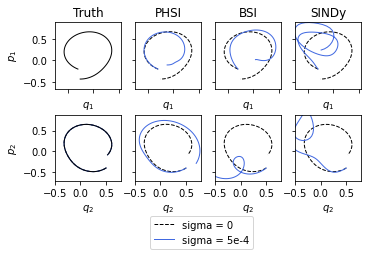

In [39]:
#plot trajectory
t_sim = np.linspace(0, 8, 101)
x0 = np.array([-0.3, 0.5, -0.2, -0.4])
x_exact, dxdt, _, _ = pH_system.sample_trajectory(t_sim, x0=x0)
nsamples = t_sim.shape[0]

x_phsi_noise, _ = phsi_noise.simulate_trajectory(integrator=False, t_sample=t_sim, x0=x0)
x_phsi, _ = phsi.simulate_trajectory(integrator=False, t_sample=t_sim, x0=x0)
x_baselinesi, _ = baselinesi.simulate_trajectory(integrator=False, t_sample=t_sim, x0=x0)
x_baselinesi_noise, _ = baselinesi_noise.simulate_trajectory(integrator=False, t_sample=t_sim, x0=x0)

x_sindy = sindy.simulate(x0, t_sim)
x_sindy_noise = sindy_noise.simulate(x0, t_sim)

x_exact = x_exact.reshape(-1, pH_system.nstates)
x_phsi = x_phsi.reshape(-1, pH_system.nstates)
x_phsi_noise = x_phsi_noise.reshape(-1, pH_system.nstates)
x_baselinesi = x_baselinesi.reshape(-1, pH_system.nstates)
x_baselinesi_noise = x_baselinesi_noise.reshape(-1, pH_system.nstates)

fig, ax = plt.subplots(2, 4)
fig.set_size_inches(5.5,3.8)
c1 = 'black'; c2 = 'royalblue'

xmin0 = min(x_exact[:,0]); xmin1 = min(x_exact[:,1])
xmax0 = max(x_exact[:,0]); xmax1 = max(x_exact[:,1])
ymin0 = min(x_exact[:,2]); ymin1 = min(x_exact[:,3])
ymax0 = max(x_exact[:,2]); ymax1 = max(x_exact[:,3])
k=2
spacex0 = 2*(xmax0-xmin0)/10; spacex1 = 2*(xmax1-xmin1)/10
spacey0 = 2*(ymax0-ymin0)/10; spacey1 = 2*(ymax1-ymin1)/10
for i in range(4):
    ax[0,i].set(xlim=(xmin0-spacex0, xmax0+spacex0), ylim=(ymin0-spacey0, ymax0+spacey0))
    ax[1,i].set(xlim=(xmin1-spacex1, xmax1+spacex1), ylim=(ymin1-spacey1, ymax1+spacey1))
for i in range(4):
    ax[0,i].set_xlabel('$q_1$')
    ax[1,i].set_xlabel('$q_2$')
for i in range(4):
    ax[0,i].set_xticklabels([])
for i in range(1,4):
    ax[0,i].set_yticklabels([]); ax[1,i].set_yticklabels([])
ax[0,0].plot(x_exact[:, 0], x_exact[:, 2], linewidth=1, color=c1)
ax[0,1].plot(x_phsi[:, 0], x_phsi[:, 2], '--', linewidth=1, color=c1)
ax[0,1].plot(x_phsi_noise[:, 0], x_phsi_noise[:, 2], linewidth=1, color=c2)
ax[0,2].plot(x_baselinesi[:, 0], x_baselinesi[:, 2], '--', linewidth=1, color=c1)
ax[0,2].plot(x_baselinesi_noise[:, 0], x_baselinesi_noise[:, 2], linewidth=1, color=c2)
ax[0,3].plot(x_sindy[:, 0], x_sindy[:, 2], '--', linewidth=1, color=c1)
ax[0,3].plot(x_sindy_noise[:, 0], x_sindy_noise[:, 2], linewidth=1, color=c2)
ax[1,0].plot(x_exact[:, 1], x_exact[:, 3], '--', linewidth=1, color=c1, label='sigma = 0')
ax[1,0].plot(x_exact[:, 1], x_exact[:, 3], linewidth=1, color=c2, label='sigma = 5e-4')
ax[1,0].plot(x_exact[:, 1], x_exact[:, 3], linewidth=1, color=c1)
ax[1,1].plot(x_phsi[:, 1], x_phsi[:, 3], '--', linewidth=1, color=c1)
ax[1,1].plot(x_phsi_noise[:, 1], x_phsi_noise[:, 3], linewidth=1, color=c2)
ax[1,2].plot(x_baselinesi[:, 1], x_baselinesi[:, 3], '--', linewidth=1, color=c1)
ax[1,2].plot(x_baselinesi_noise[:, 1], x_baselinesi_noise[:, 3], linewidth=1, color=c2)
ax[1,3].plot(x_sindy[:, 1], x_sindy[:, 3], '--', linewidth=1, color=c1)
ax[1,3].plot(x_sindy_noise[:, 1], x_sindy_noise[:, 3], linewidth=1, color=c2)
ax[1,0].legend(loc='lower center', bbox_to_anchor=(2.2, -1.1),
     fancybox=True)
ax[0,0].set_ylabel('$p_1$')
ax[1,0].set_ylabel('$p_2$')
ax[0,0].set_title('Truth')
ax[0,1].set_title('PHSI')
ax[0,2].set_title('BSI')
ax[0,3].set_title('SINDy')
fig.subplots_adjust(bottom=0.3, hspace=0.4)
plt.savefig('plots/NLS/nls_trajectory.pdf')
print(x0)

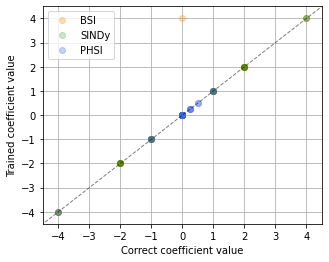

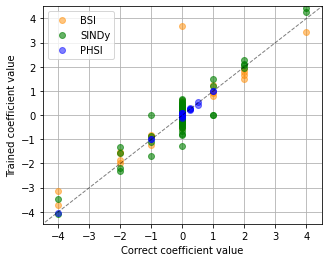

In [16]:
#coefficient plot
correct_phsi = np.array(3*[0] + [0.25] + 4*[0] + [-1] + 3*[0] + [0.5, 0, 0, 1] + 7*[0] + [-4] \
    + 14*[0] + [0.25, 0, 0, 0, 1, 0, 0, 0.5] + 12*[0] + [0.25, 0, 0, -1] + 6*[0] + [0.25])

correct_sindy = np.array([
    17*[0] + [1] + 3*[0] + [-4] + 4*[0] + [2] + 4*[0] + [1,0,-2,0],
    18*[0] + [2, 0, -4] + 6*[0] + [1] + 4*[0] + [-2,0,1],
    15*[0] + [-1] + 3*[0] + [2] + 2*[0] + [-1, 0, -2] + 4*[0] + [4] + 5*[0],
    16*[0] + [2] + 6*[0] + [4, 0, -1] + 2*[0] + [-2, 0, -1] + 4*[0]
])

correct_baselinesi = np.array([
    5*[0] + [1] + 4*[0] + [-4] + 8*[0] + [2] + 8*[0] + [1] + 2*[0] + [-2] + 3*[0],
    6*[0] + [2] + 2*[0] + [-4] + 10*[0] + [1] + 8*[0] + [-2] + 4*[0] + [1],
    3*[0] + [-1] + 4*[0] + [2] + 3*[0] + [-1] + 2*[0] + [-2] + 7*[0] + [4] + 11*[0],
    4*[0] + [2] + 13*[0] + [-1] + 3*[0] + [-2] + 2*[0] + [-1] + 9*[0]
]).T

#noiseless
fig, ax = plt.subplots()
fig.set_size_inches(5,4)
ax.plot(correct_baselinesi.flatten(), baselinesi.layer.detach().flatten(), 'go', color=c_baseline, label='BSI', alpha=0.3)
ax.plot(correct_sindy.flatten(), sindy.coefficients().flatten(), 'bo', color=c_sindy, label='SINDy', alpha=0.2)
ax.plot(correct_phsi, phsi.layer.detach(), 'ro', color=c_phsi, label='PHSI', alpha=0.3)
ax.plot([-10,10], [-10,10], 'k--', linewidth=1, alpha=0.5)
ax.axis([-4.5,4.5,-4.5,4.5])
ax.grid(True)
ax.set_xlabel('Correct coefficient value')
ax.set_ylabel('Trained coefficient value')
ax.legend(fancybox=True)
plt.savefig('plots/NLS/nls_coeff.pdf')
plt.show()

#noisy
fig2, ax2 = plt.subplots()
fig2.set_size_inches(5,4)
ax2.plot(correct_baselinesi.flatten(), baselinesi_noise.layer.detach().flatten(), 'go', color=c_baseline, label='BSI', alpha=0.5)
ax2.plot(correct_sindy.flatten(), sindy_noise.coefficients().flatten(), 'go', label='SINDy', alpha=0.6)
ax2.plot(correct_phsi, phsi_noise.layer.detach(), 'bo', label='PHSI', alpha=0.5)
ax2.plot([-10,10], [-10,10], 'k--', linewidth=1, alpha=0.5)
ax2.axis([-4.5,4.5,-4.5,4.5])
ax2.grid(True)
ax2.set_xlabel('Correct coefficient value')
ax2.set_ylabel('Trained coefficient value')
ax2.legend(fancybox=True)
plt.savefig('plots/NLS/nls_coeff_noise.pdf')